In [157]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import RobustScaler,Normalizer, PowerTransformer,FunctionTransformer, PolynomialFeatures, KBinsDiscretizer
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.feature_selection
import sklearn.tree
import sklearn.svm
import sklearn.metrics
import matplotlib.pyplot as plt
import csv

### Function to test many different models

In [190]:
# MODELING
def testAllModels(X,Y,allModelTypes,scoreNum):
    modelTypeNames=['DecisionTreeRegressor', 'KNeighborsRegressor', 'SVMregression','LinearRegression', 'ElasticNet', 'RidgeRegression', 'Lasso' ]
    #spliting to train and test 
    x_tr, x_te, y_tr, y_te=sklearn.model_selection.train_test_split(X, Y, test_size=setup["ratio_test_set"],  random_state=setup["random_generator"]) 
    numFeatures=x_tr.shape[1]
    #opening .cvs file for that Score
    fscores = open(outputFolderNameFinal+"/IQscore_"+str(scoreNum)+"_OptimizedModels.csv", 'w',newline='')
    writerScores = csv.writer(fscores)
    #writerScores = csv.writer(open(outputFolderNameFinal+"/IQscore_"+str(scoreNum)+"_OptimizedModels.csv", 'w'))
    
    for m in range(len(allModelTypes)):

        modelType=allModelTypes[m]
        print('--> modelType: '+ modelTypeNames[allModelTypes[m]-1])
        estimators = []
        param_grid = {}

        #PREPROCESING PIPELINE 
        preprocess=Pipeline([
            ('gauss', PowerTransformer()),
            ('scale', RobustScaler(with_scaling=True, with_centering=True)),
            #('scale', Normalizer()),
            ])
        # appending model to pipleline  
        #setting parameters for grid search
        param_grid["preprocess__gauss"]=[None,PowerTransformer(method='yeo-johnson')]
        param_grid["preprocess__scale__quantile_range"]=[(0,1),(0.15,0.85),(0.25,0.75)]
        # columns to have latter in export file 
        colsPreprocess=["scale__quantile_range","gauss"]
        estimators.append(('preprocess', preprocess))
        
         # APPENDING FEATURE SELECTION TO PIPELINE 
        param_grid["feature_selection__k"] = [round(numFeatures*x) for x in setup["percOfFeaturesToKeep"]]
        param_grid["feature_selection__score_func"]=[sklearn.feature_selection.f_regression,sklearn.feature_selection.mutual_info_regression] #sklearn.feature_selection.chi2,
        colsFeatSelect=["k","score_func"]
        estimators.append(('feature_selection', sk.feature_selection.SelectKBest()))

        #SELECTING MODEL AND APPENDING TO PIPELINE
        # DecisionTreeRegressor
        if (modelType==1):
            fileName="DecisionTree"
            colsModel=["max_depth","min_samples_leaf","max_features"]
            param_grid["model__max_depth"]=[None,2,4,6,8,14,20]
            param_grid["model__min_samples_leaf"]=[1,2,3,5,8,14]
            param_grid["model__max_features"]=[None,'sqrt','log2']
            estimators.append(('model', sklearn.tree.DecisionTreeRegressor( random_state=setup["random_generator"])))
        # KNeighborsRegressor
        elif (modelType==2):
            fileName="KNeighbour"
            colsModel=["n_neighbors","weights","p"]
            param_grid["model__n_neighbors"]=[2,4,6,10]
            param_grid["model__weights"]=['uniform','distance']
            param_grid["model__p"]=[1,2]
            estimators.append(('model',  sklearn.neighbors.KNeighborsRegressor( algorithm='auto', n_jobs=setup["nr_parallel_processes"])))
        #SVR (support vector regression)
        elif (modelType==3):
            fileName="SVMregression"
            colsModel=["C","kernel","degree","gamma"]
            param_grid["model__C"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            param_grid["model__kernel"]=['rbf','linear', 'poly']
            param_grid["model__degree"]=[2,3]
            param_grid["model__gamma"]=['auto','scale']
            estimators.append(('model',sklearn.svm.SVR( max_iter=setup["max_iter"])))
        # linear regression 
        elif (modelType==4):
            fileName="LinearRegression"
            colsModel=[]
            estimators.append(('model', sklearn.linear_model.LinearRegression( n_jobs=setup["nr_parallel_processes"])))
        # elastic net
        elif (modelType==5):
            fileName="ElasticNet"
            colsModel=["alpha","l1_ratio"] 
            param_grid["model__alpha"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            param_grid["model__l1_ratio"]=[0.3,0.5,0.8]
            estimators.append(('model', sklearn.linear_model.ElasticNet( max_iter=setup["max_iter"], random_state=setup["random_generator"])))
        #ridge
        elif (modelType==6):
            fileName="RidgeRegression"
            colsModel=["alpha"] 
            param_grid["model__alpha"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            estimators.append(('model',sklearn.linear_model.Ridge( max_iter=setup["max_iter"],  solver='auto', random_state=setup["random_generator"])))
        #lasso
        elif (modelType==7):
            fileName="Lasso"
            colsModel=["alpha"] 
            param_grid["model__alpha"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            estimators.append(('model',sklearn.linear_model.Lasso( max_iter=setup["max_iter"], random_state=setup["random_generator"])))



        #-------------------------------------------------------------------------------------------
        # CREATING FINAL PIPELINE 
        full_pipeline = Pipeline(estimators)


        # GRID SEARCH FOR OPTIMAL PARAMETERS
        #setting up score metrics 
        score=sklearn.metrics.make_scorer(sklearn.metrics.r2_score)  # explained_variance_score
        clf = sklearn.model_selection.GridSearchCV(full_pipeline, param_grid, scoring=score, iid=False, n_jobs=-1,cv=setup["numCV"]) # verbose=100
        clf = clf.fit(x_tr, y_tr)

        #PRINTING PERFORMANCE ON TRAIN AND TEST 
        #train
        pred_tr = clf.predict(x_tr)
        print(sklearn.metrics.r2_score(y_tr, pred_tr)) 
        score_tr=sklearn.metrics.r2_score(y_tr, pred_tr)
         #test
        pred_te = clf.predict(x_te)
        print(sklearn.metrics.r2_score(y_te, pred_te))  
        score_te=sklearn.metrics.r2_score(y_te, pred_te)

        #PLOTTING PREDICTION VS TRUE LABELS 
        #train 
        plt.figure(1,figsize=(8,5))
    #    plt.subplot(2, 3, m+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.scatter(y_tr,pred_tr, linestyle='-', marker='o')
        plt.grid(True); #plt.axis([1, 8, ymin, ymax]);
        plt.ylabel('prediction')
        plt.xlabel('true label')
        plt.title(fileName+'_train')

        #test
        plt.figure(2,figsize=(8,5))
    #    plt.subplot(2, 3, m+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.scatter(y_te,pred_te, linestyle='-', marker='o')
        plt.grid(True); #plt.axis([1, 8, ymin, ymax]);
        plt.ylabel('prediction')
        plt.xlabel('true label')
        plt.title(fileName+'_test')


        #-------------------------------------------------------------------------------------------
        # STORING DATA IN A SUPER NICE WAY!!
        #creating columns to keep in final table for .cvs 
        colsFinal=[]
        for c in range(len(colsPreprocess)):
            colsFinal=colsFinal+['param_preprocess__'+colsPreprocess[c]]
        for c in range(len(colsFeatSelect)):
            colsFinal=colsFinal+['param_feature_selection__'+colsFeatSelect[c]]
        for c in range(len(colsModel)):
            colsFinal=colsFinal+['param_model__'+colsModel[c]]
        colsEvaluation=["rank_test_score","mean_test_score","mean_train_score","std_test_score","std_train_score"]
        colsFinal=colsFinal+colsEvaluation

        #selection columns, sorting and exporting to .csv
        df1 = pd.DataFrame(clf.cv_results_,columns=colsFinal)#
        df1=df1.sort_values(by="mean_test_score",ascending=False)
        df1.to_csv(outputFolderName+ '/AllParameterOptimizing_'+fileName+'ScoreNum_'+str(scoreNum)+'.csv')

        #writing to a file 
        allResults=[m,modelTypeNames[allModelTypes[m]-1],score_tr,score_te]
        writerScores.writerow(allResults)
    
    
    fscores.close()
    print('Done!')
        

### Setup

In [158]:
setup={
    "random_generator":2,
    "ratio_test_set":0.25,
    "nr_parallel_processes":-1, #as much as available 
    "max_iter":1000,
    "numCV":3,
    "percOfFeaturesToKeep":[0.2, 0.4, 0.6, 0.8, 1] #if -1 is off
}

#WHICH MODELS TO TEST 
allModelTypes=[1,2,4,5,6]

#CREATING OUTPUT FOLDER 
outputFolderName='MLmodelResults'
outputFolderNameFinal='MLmodelOptimized'
#create folder if doesnt exist 
try:
    os.stat(outputFolderName)
except:
    os.mkdir(outputFolderName)
try:
    os.stat(outputFolderNameFinal)
except:
    os.mkdir(outputFolderNameFinal)

### Testing models 

In [ ]:
# loading features
fileName="features_funcConn_Pearson_D1D2inTime.csv"
#fileName="features_funcConn_Pearson_D1D2D3D4.csv"
data_path = os.path.abspath(fileName)
allData = np.genfromtxt(data_path, delimiter=",", skip_header=0)
X=allData
print('features size: '+str(X.shape))

#loading labels
fileName="IQscores.csv"
data_path = os.path.abspath(fileName)
labels = np.genfromtxt(data_path, delimiter=",", skip_header=0)
print('labels size: '+ str(Y.shape))

IQ score num: 22
--> modelType: RidgeRegression
0.4504149737295272
-0.014868773407538116
--> modelType: Lasso
0.446096198334373
0.0033618514573418024
Done!


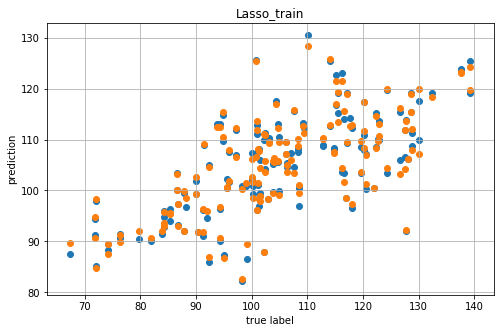

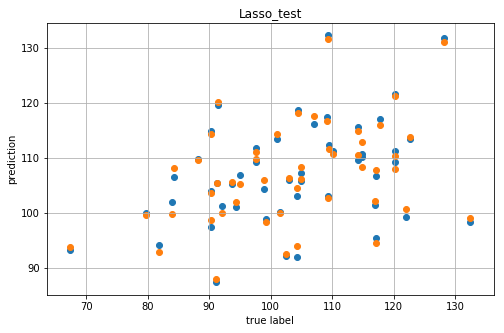

In [191]:
#SELECT MODELS TO TEST 
allModelTypes=[1,4,5,6,7]# [1,2,3,4,5,6,7]
(numSubj,numLabels)=labels.shape
for lab in range(0,numLabels):
#for score in range(22,23):
    print('IQ score num: '+ str(score))
    Y=labels[:,score]
    testAllModels(X,Y,allModelTypes, score)
    